In [1]:
! pip install -U scikit-learn

In [1]:
import illustris_python as il
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib
import matplotlib.pyplot as plt

In [2]:
from sklearn import metrics
from sklearn.model_selection import cross_validate, KFold, cross_val_predict, GridSearchCV

from sklearn.tree import DecisionTreeRegressor

from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor

from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

from sklearn.neighbors import KNeighborsRegressor

In [3]:
! wget -nc --content-disposition --header="API-Key: e2697a415abd570c10a94b88d11b044a" "http://www.tng-project.org/api/TNG100-1/files/stellar_photometry.91.hdf5"

URL transformed to HTTPS due to an HSTS policy
--2023-09-27 10:12:29--  https://www.tng-project.org/api/TNG100-1/files/stellar_photometry.91.hdf5
Resolving www.tng-project.org (www.tng-project.org)... 130.183.17.94
Connecting to www.tng-project.org (www.tng-project.org)|130.183.17.94|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://data-eu.tng-project.org/file/stellar_photometry/L75n1820TNG/91/?token=e518c37636efabdb913e [following]
--2023-09-27 10:12:29--  https://data-eu.tng-project.org/file/stellar_photometry/L75n1820TNG/91/?token=e518c37636efabdb913e
Resolving data-eu.tng-project.org (data-eu.tng-project.org)... 130.183.17.94
Connecting to data-eu.tng-project.org (data-eu.tng-project.org)|130.183.17.94|:443... connected.
HTTP request sent, awaiting response... 200 OK


In [4]:
import h5py

with h5py.File('Subhalo_StellarPhot_p07c_cf00dust_res_conv_ns1_rad30pkpc_091.hdf5', 'r') as hf:
    print (list (hf.keys()))
    s_id = hf['subhaloIDs'][:]
    phot = hf['Subhalo_StellarPhot_p07c_cf00dust_res_conv_ns1_rad30pkpc'][:]

['Subhalo_StellarPhot_p07c_cf00dust_res_conv_ns1_rad30pkpc', 'subhaloIDs']


In [5]:
s_id.shape

(4449889,)

In [6]:
basePath = '../sims.TNG/TNG100-1/output'

In [7]:
mtype = il.groupcat.loadSubhalos(basePath, 91, fields=['SubhaloMassType'])
gmetal = il.groupcat.loadSubhalos(basePath, 91, fields=['SubhaloGasMetallicity'])
sfr = il.groupcat.loadSubhalos(basePath, 91, fields=['SubhaloSFR'])

In [8]:
sfr.shape

(4449889,)

In [9]:
pdgmetal = pd.DataFrame(gmetal, columns=['Gas Metallicity'])
pdsfr = pd.DataFrame(sfr, columns=['Stellar Formation Rate'])
pds_id = pd.DataFrame(s_id, columns =['Subhalo ID'])

In [10]:
gmass = mtype[:,0]
dmmass = mtype[:,1]
stmass = mtype[:,4]
bhmass = mtype[:,5]

In [11]:
pdgmass = np.log10((pd.DataFrame(gmass, columns=['Gas Mass']))*(10**10))
pddmmass = np.log10((pd.DataFrame(dmmass, columns=['Dark Matter Mass']))*(10**10))
pdstmass = np.log10((pd.DataFrame(stmass, columns=['Stellar Mass']))*(10**10))
pdbhmass = np.log10((pd.DataFrame(bhmass, columns=['Black Hole Mass']))*(10**10))

/opt/conda/lib/python3.11/site-packages/pandas/core/internals/blocks.py:329: RuntimeWarning: divide by zero encountered in log10
  result = func(self.values, **kwargs)


In [12]:
pdgmass

,Gas Mass
0,13.560769
1,10.616130
2,9.833848
3,8.702189
4,10.616083
...,...
4449884,-inf
4449885,-inf
4449886,-inf
4449887,-inf


In [13]:
pdgmetal.replace(to_replace = 0, value = 10**-8, inplace=True)
pdsfr.replace(to_replace = 0, value = 10**-8, inplace=True)
pdgmass.replace(to_replace = -np.inf, value = 8, inplace=True)
pddmmass.replace(to_replace = -np.inf, value = 8, inplace=True)
pdstmass.replace(to_replace = -np.inf, value = 8, inplace=True)
pdbhmass.replace(to_replace = -np.inf, value = 8, inplace=True) 

pdgmetal.fillna(0,inplace=True)
pdsfr.fillna(0,inplace=True)
pdgmass.fillna(0,inplace=True)
pddmmass.fillna(0,inplace=True)
pdstmass.fillna(0,inplace=True)
pdbhmass.fillna(0,inplace=True)

In [14]:
df = pd.DataFrame(pdgmetal)
df['Stellar Formation Rate'] = pdsfr
df['Gas Mass'] = pdgmass
df['Stellar Mass'] = pdstmass
df['Black Hole Mass'] = pdbhmass
df['Dark Matter Mass'] = pddmmass
df['Subhalo ID'] = pds_id

In [15]:
df['Stellar Mass'] = df['Stellar Mass'][(df['Stellar Mass'] > 9)]
df['Dark Matter Mass'] = df['Dark Matter Mass'][(df['Dark Matter Mass'] > 9)]

In [16]:
df

,Gas Metallicity,Stellar Formation Rate,Gas Mass,Stellar Mass,Black Hole Mass,Dark Matter Mass,Subhalo ID
0,3.920325e-03,1.191226e+01,13.560769,12.189700,9.722685,14.337951,0
1,1.873566e-02,3.078836e+01,10.616130,11.680132,9.218714,12.360020,1
2,1.576501e-02,1.733503e+00,9.833848,11.401999,8.900289,12.290783,2
3,1.192400e-02,1.000000e-08,8.702189,11.214507,8.796812,12.363271,3
4,1.047468e-02,1.204401e+00,10.616083,11.025040,8.616725,12.339453,4
...,...,...,...,...,...,...,...
4449884,1.000000e-08,1.000000e-08,8.000000,NaN,8.000000,NaN,4449884
4449885,1.000000e-08,1.000000e-08,8.000000,NaN,8.000000,NaN,4449885
4449886,1.000000e-08,1.000000e-08,8.000000,NaN,8.000000,NaN,4449886
4449887,1.000000e-08,1.000000e-08,8.000000,NaN,8.000000,NaN,4449887


In [17]:
ddf = df.dropna()

In [18]:
ddf

,Gas Metallicity,Stellar Formation Rate,Gas Mass,Stellar Mass,Black Hole Mass,Dark Matter Mass,Subhalo ID
0,3.920325e-03,1.191226e+01,13.560769,12.189700,9.722685,14.337951,0
1,1.873566e-02,3.078836e+01,10.616130,11.680132,9.218714,12.360020,1
2,1.576501e-02,1.733503e+00,9.833848,11.401999,8.900289,12.290783,2
3,1.192400e-02,1.000000e-08,8.702189,11.214507,8.796812,12.363271,3
4,1.047468e-02,1.204401e+00,10.616083,11.025040,8.616725,12.339453,4
...,...,...,...,...,...,...,...
746965,1.000000e-08,1.000000e-08,8.000000,9.070190,8.000000,10.350875,746965
757298,1.000000e-08,1.000000e-08,8.000000,9.032024,8.000000,10.256576,757298
772129,2.301487e-02,1.872653e-02,8.282676,9.004390,8.000000,9.991588,772129
778887,1.000000e-08,1.000000e-08,8.000000,9.002027,8.000000,10.200853,778887


In [19]:
reshaped_phot = phot.reshape(4449889, 8 * 12)

colu = []
for f in range(8):
    for sub in range(12):
        colu.append(f'feature_{f}_sub_{sub}')
ph = pd.DataFrame(data=reshaped_phot, columns=colu)
ph['Subhalo ID'] = pds_id

matching_elements = []
for i in ph['Subhalo ID']:
    if i in ddf['Subhalo ID'].values:
        matching_elements.append(i)
    else :
        matching_elements.append(np.nan)     
matching_series = pd.Series(matching_elements)

In [20]:
matching_elements = np.zeros(len(ph['Subhalo ID']))
for idx, i in enumerate(ph['Subhalo ID']):
    if i in ddf['Subhalo ID'].values:
        matching_elements[idx] = i
    else :
        matching_elements[idx] = np.nan
                             
matching_series = pd.Series(matching_elements)

In [21]:
matching_series

0          0.0
1          1.0
2          2.0
3          3.0
4          4.0
          ... 
4449884    NaN
4449885    NaN
4449886    NaN
4449887    NaN
4449888    NaN
Length: 4449889, dtype: float64

In [23]:
#pph = ph.dropna()
#for f in range(8):
    #for sub in range(1, 12):
        #pph = pph.drop(columns=(f'feature_{f}_sub_{sub}'))

In [22]:
pph = ph.dropna()
for f in range(8):
    for sub in range(1, 12):
        pph = pph.drop(columns=(f'feature_{f}_sub_{sub}'))   
    if f > 4: 
        pph = pph.drop(columns=(f'feature_{f}_sub_0'))

In [23]:
pph['u-g'] = pph['feature_0_sub_0'] - pph['feature_1_sub_0']
pph['g-r'] = pph['feature_1_sub_0'] - pph['feature_2_sub_0']
pph['r-i'] = pph['feature_2_sub_0'] - pph['feature_3_sub_0']
pph['i-z'] = pph['feature_3_sub_0'] - pph['feature_4_sub_0']

In [24]:
pph['Matched IDs'] = matching_series
ppph = pph.dropna()

In [25]:
ppph

,feature_0_sub_0,feature_1_sub_0,feature_2_sub_0,feature_3_sub_0,feature_4_sub_0,Subhalo ID,u-g,g-r,r-i,i-z,Matched IDs
0,-20.593021,-22.422171,-23.232534,-23.637362,-23.995768,0,1.829149,0.810364,0.404827,0.358406,0.0
1,-21.890554,-23.154871,-23.729202,-24.056564,-24.364653,1,1.264317,0.574331,0.327362,0.308088,1.0
2,-20.367485,-21.993053,-22.700130,-23.067825,-23.393227,2,1.625568,0.707077,0.367695,0.325401,2.0
3,-19.557058,-21.306505,-22.087584,-22.480154,-22.819138,3,1.749447,0.781078,0.392570,0.338984,3.0
4,-19.595139,-21.141136,-21.839962,-22.205723,-22.526999,4,1.545998,0.698826,0.365761,0.321276,4.0
...,...,...,...,...,...,...,...,...,...,...,...
746965,-15.285927,-16.838699,-17.534170,-17.881359,-18.150757,746965,1.552773,0.695471,0.347189,0.269398,746965.0
757298,-15.135825,-16.690088,-17.383066,-17.731005,-18.002151,757298,1.554263,0.692978,0.347939,0.271147,757298.0
772129,-15.190722,-16.700409,-17.358328,-17.701681,-17.982338,772129,1.509686,0.657919,0.343353,0.280657,772129.0
778887,-15.257939,-16.776371,-17.452665,-17.786982,-18.041084,778887,1.518432,0.676294,0.334316,0.254103,778887.0


In [26]:
co = ddf.merge(pph, how = 'inner')

In [27]:
co

,Gas Metallicity,Stellar Formation Rate,Gas Mass,Stellar Mass,Black Hole Mass,Dark Matter Mass,Subhalo ID,feature_0_sub_0,feature_1_sub_0,feature_2_sub_0,feature_3_sub_0,feature_4_sub_0,u-g,g-r,r-i,i-z,Matched IDs
0,3.920325e-03,1.191226e+01,13.560769,12.189700,9.722685,14.337951,0,-20.593021,-22.422171,-23.232534,-23.637362,-23.995768,1.829149,0.810364,0.404827,0.358406,0.0
1,1.873566e-02,3.078836e+01,10.616130,11.680132,9.218714,12.360020,1,-21.890554,-23.154871,-23.729202,-24.056564,-24.364653,1.264317,0.574331,0.327362,0.308088,1.0
2,1.576501e-02,1.733503e+00,9.833848,11.401999,8.900289,12.290783,2,-20.367485,-21.993053,-22.700130,-23.067825,-23.393227,1.625568,0.707077,0.367695,0.325401,2.0
3,1.192400e-02,1.000000e-08,8.702189,11.214507,8.796812,12.363271,3,-19.557058,-21.306505,-22.087584,-22.480154,-22.819138,1.749447,0.781078,0.392570,0.338984,3.0
4,1.047468e-02,1.204401e+00,10.616083,11.025040,8.616725,12.339453,4,-19.595139,-21.141136,-21.839962,-22.205723,-22.526999,1.545998,0.698826,0.365761,0.321276,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17250,1.000000e-08,1.000000e-08,8.000000,9.070190,8.000000,10.350875,746965,-15.285927,-16.838699,-17.534170,-17.881359,-18.150757,1.552773,0.695471,0.347189,0.269398,746965.0
17251,1.000000e-08,1.000000e-08,8.000000,9.032024,8.000000,10.256576,757298,-15.135825,-16.690088,-17.383066,-17.731005,-18.002151,1.554263,0.692978,0.347939,0.271147,757298.0
17252,2.301487e-02,1.872653e-02,8.282676,9.004390,8.000000,9.991588,772129,-15.190722,-16.700409,-17.358328,-17.701681,-17.982338,1.509686,0.657919,0.343353,0.280657,772129.0
17253,1.000000e-08,1.000000e-08,8.000000,9.002027,8.000000,10.200853,778887,-15.257939,-16.776371,-17.452665,-17.786982,-18.041084,1.518432,0.676294,0.334316,0.254103,778887.0


In [28]:
#Features = co[['feature_0_sub_0','feature_1_sub_0','feature_2_sub_0','feature_3_sub_0','feature_4_sub_0','feature_5_sub_0','feature_6_sub_0','feature_7_sub_0']]
#Target = co['Dark Matter Mass']
#X_train, X_test, Y_train, Y_test = train_test_split(Features, Target, test_size=0.1)

In [43]:
Features = co[['u-g','g-r','r-i','i-z', 'feature_0_sub_0','feature_1_sub_0','feature_2_sub_0','feature_3_sub_0','feature_4_sub_0']]
Target = co['Stellar Mass']
X_train, X_test, Y_train, Y_test = train_test_split(Features, Target, test_size=0.2)

In [44]:
X_train.shape

(13804, 9)

In [45]:
Target.shape

(17255,)

feature importance :  [5.47879568e-04 2.15192343e-03 1.43033784e-02 2.52758335e-02
 4.10402391e-04 3.61264288e-04 3.33739724e-04 4.87160304e-03
 9.51743976e-01]
prediction :  [ 9.19076633 10.67621136 10.33437729 ...  9.47546101  9.16619873
  9.43184471]
R2 Score :  0.9922178344986063
The mean square value :  0.0024536507508578736
The Score :  {'fit_time': array([0.24310803, 0.23746037, 0.27214646, 0.26804161, 0.23558044,
       0.23175812, 0.23385191]), 'score_time': array([0.00347447, 0.00351453, 0.00450659, 0.00330687, 0.00340772,
       0.00330734, 0.00315714]), 'test_score': array([0.99223932, 0.99161936, 0.99196262, 0.99187528, 0.99250515,
       0.99169715, 0.99215731]), 'train_score': array([1., 1., 1., 1., 1., 1., 1.])}
Test Score :  0.992008027038482
Train Score :  1.0
Cross Vaidate prediction :  [11.91481781 11.90595531 11.49978447 ...  9.03286743  9.03319931
  9.00778103]


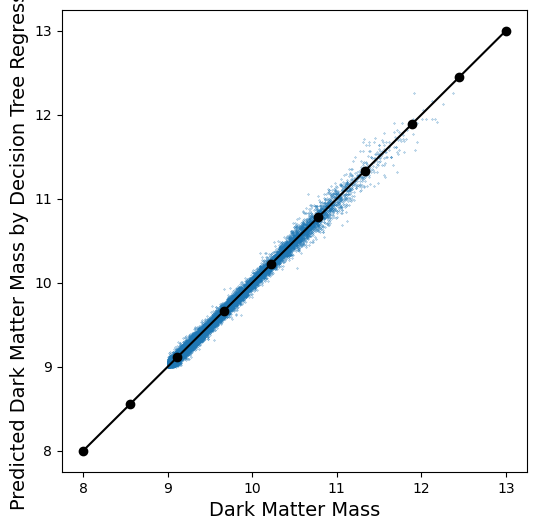

In [46]:
Regressor = DecisionTreeRegressor()
Regressor.fit(X_train, Y_train)
ft = Regressor.feature_importances_
print ("feature importance : ", ft)

Y_pred = Regressor.predict(X_test)
print ("prediction : ", Y_pred)

R = r2_score(Y_test, Y_pred)
print ("R2 Score : ", R)

Mse = mean_squared_error(Y_test, Y_pred)
print ("The mean square value : ", Mse)

Scores = cross_validate(Regressor,Features,Target, cv = KFold(n_splits=7, shuffle=True, random_state=10), return_train_score=True)
S = np.mean(Scores['test_score'])
print ("The Score : ", Scores)
print ("Test Score : ", S)
print ("Train Score : ", np.mean(Scores['train_score']))

Cvpred = cross_val_predict(Regressor,Features,Target, cv = KFold(n_splits=7, shuffle=True, random_state=10))
print ("Cross Vaidate prediction : ", Cvpred)

m = np.linspace(8, 13, 10)
n = m

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)
ax.plot(Target,Cvpred, '.', markersize=0.5)
ax.plot(m, n, color='black', linestyle='-', marker='o')
ax.set_xlabel('Dark Matter Mass', fontsize=14)
ax.set_ylabel('Predicted Dark Matter Mass by Decision Tree Regressor',fontsize=14)
plt.show()

feature importance :  [4.84373360e-04 2.20364243e-03 1.42686148e-02 2.52748812e-02
 4.34645307e-04 3.53931642e-04 3.63032635e-04 6.81952882e-04
 9.55934926e-01]
prediction :  [ 9.19076633 10.69516468 10.33437729 ...  9.47555542  9.16870975
  9.43184471]
R2 Score :  0.9924278850092134
The mean square value :  0.0023874236071436006
The Score :  {'fit_time': array([0.24028516, 0.23748708, 0.25548983, 0.31071305, 0.31301475,
       0.30783439, 0.31188536]), 'score_time': array([0.00355196, 0.00349116, 0.00399756, 0.00412869, 0.00398588,
       0.0039885 , 0.00402904]), 'test_score': array([0.99216043, 0.99158939, 0.99192102, 0.991729  , 0.99253968,
       0.99167066, 0.99248684]), 'train_score': array([1., 1., 1., 1., 1., 1., 1.])}
Test Score :  0.9920138591009954
Train Score :  1.0
Cross Vaidate prediction :  [11.91481781 11.90595531 11.49978447 ...  9.03286743  9.03319931
  9.03368092]
Pearson Correlation Coefficient: 0.9960326047216622
P-value: 0.0


Text(0, 0.5, 'Predicted Dark Matter Mass by Decision Tree Regressor')

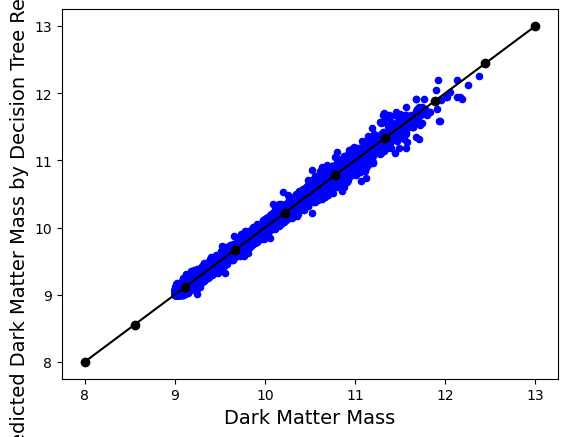

In [47]:
Regressor = DecisionTreeRegressor()
Regressor.fit(X_train, Y_train)
ft = Regressor.feature_importances_
print ("feature importance : ", ft)

Y_pred = Regressor.predict(X_test)
print ("prediction : ", Y_pred)

R = r2_score(Y_test, Y_pred)
print ("R2 Score : ", R)

Mse = mean_squared_error(Y_test, Y_pred)
print ("The mean square value : ", Mse)

Scores = cross_validate(Regressor,Features,Target, cv = KFold(n_splits=7, shuffle=True, random_state=10), return_train_score=True)
S = np.mean(Scores['test_score'])
print ("The Score : ", Scores)
print ("Test Score : ", S)
print ("Train Score : ", np.mean(Scores['train_score']))

Cvpred = cross_val_predict(Regressor,Features,Target, cv = KFold(n_splits=7, shuffle=True, random_state=10))
print ("Cross Vaidate prediction : ", Cvpred)

C_coeff, P_value = stats.pearsonr(Cvpred.reshape((17255,)), Target)
print("Pearson Correlation Coefficient:", C_coeff)
print("P-value:", P_value)

m = np.linspace(8, 13, 10)
n = m
plt.plot(m, n, color='black', linestyle='-', marker='o')

plt.scatter(Target,Cvpred, s = 20, c = 'blue')
plt.xlabel('Dark Matter Mass', fontsize=14)
plt.ylabel('Predicted Dark Matter Mass by Decision Tree Regressor',fontsize=14)

prediction :  [ 9.181628  10.708737  10.3393545 ...  9.464681   9.180333   9.463433 ]
R2 Score :  0.9933577132241562
The mean square value :  0.0020942567
The Score :  {'fit_time': array([0.05046415, 0.04904318, 0.04990125, 0.05004311, 0.04848719,
       0.04844093, 0.04782653]), 'score_time': array([0.02425194, 0.0277288 , 0.02288342, 0.02151537, 0.02114153,
       0.02102089, 0.01979828]), 'test_score': array([0.99309346, 0.99347307, 0.99328799, 0.99391121, 0.99386168,
       0.99245133, 0.99319242]), 'train_score': array([0.99676438, 0.99673508, 0.99673702, 0.99667576, 0.99666632,
       0.99682667, 0.99674249])}
Test Score :  0.9933244515440479
Train Score :  0.9967353893417047
Cross Vaidate prediction :  [11.823997  11.882438  11.417478  ...  9.0359335  9.036206   9.034377 ]
Pearson Correlation Coefficient: 0.9966611821003097
P-value: 0.0


Text(0, 0.5, 'Predicted Dark Matter Mass by KNN Regressor')

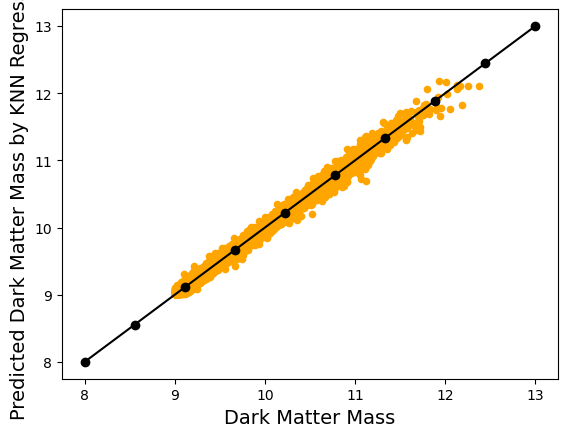

In [48]:
KnnRegressor = KNeighborsRegressor(n_neighbors=3)
KnnRegressor.fit(X_train, Y_train)

KY_pred = KnnRegressor.predict(X_test)
print ("prediction : ", KY_pred)

KR = r2_score(Y_test, KY_pred)
print ("R2 Score : ", KR)

KMse = mean_squared_error(Y_test, KY_pred)
print ("The mean square value : ", KMse)

KScores = cross_validate(KnnRegressor,Features,Target, cv = KFold(n_splits=7, shuffle=True, random_state=10), return_train_score=True)
KS = np.mean(KScores['test_score'])
print ("The Score : ", KScores)
print ("Test Score : ", KS)
print ("Train Score : ", np.mean(KScores['train_score']))

KCvpred = cross_val_predict(KnnRegressor,Features,Target, cv = KFold(n_splits=7, shuffle=True, random_state=10))
print ("Cross Vaidate prediction : ", KCvpred)

KC_coeff, KP_value = stats.pearsonr(KCvpred.reshape((17255,)), Target)
print("Pearson Correlation Coefficient:", KC_coeff)
print("P-value:", KP_value)

m = np.linspace(8, 13, 10)
n = m
plt.plot(m, n, color='black', linestyle='-', marker='o')

plt.scatter(Target,KCvpred, s = 20, c = 'orange')
plt.xlabel('Dark Matter Mass', fontsize=14)
plt.ylabel('Predicted Dark Matter Mass by KNN Regressor',fontsize=14)

prediction :  [ 9.162977  10.699555  10.355756  ...  9.474211   9.1497755  9.452719 ]
R2 Score :  0.9938283047986398
The mean square value :  0.0019458832
The Score :  {'fit_time': array([0.02159309, 0.01366401, 0.01718235, 0.01254869, 0.01459169,
       0.01228404, 0.01174784]), 'score_time': array([0.01847816, 0.00529909, 0.01417518, 0.01183581, 0.01069403,
       0.0137248 , 0.02763724]), 'test_score': array([0.99325459, 0.9941038 , 0.9938498 , 0.99436922, 0.99406908,
       0.99309938, 0.99356708]), 'train_score': array([0.99385272, 0.99371171, 0.99375328, 0.9936674 , 0.99371477,
       0.9938743 , 0.99380171])}
Test Score :  0.9937589930020773
Train Score :  0.9937679841076497
Cross Vaidate prediction :  [11.623632  11.62838   11.29383   ...  8.9847355  8.991749   8.973155 ]
Pearson Correlation Coefficient: 0.9968767463904961
P-value: 0.0


Text(0, 0.5, 'Predicted Dark Matter Mass by Linear Regressor')

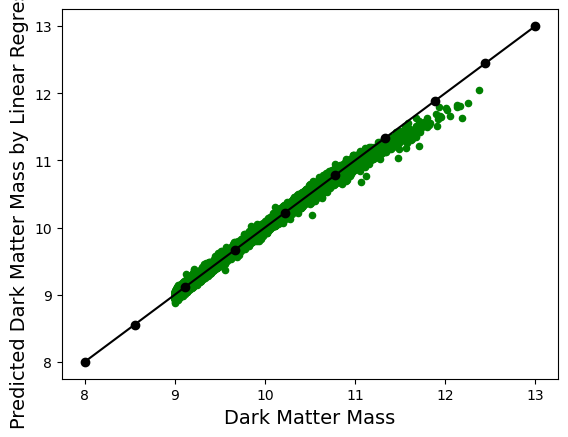

In [49]:
LRegressor = LinearRegression()
LRegressor.fit(X_train, Y_train)

LY_pred = LRegressor.predict(X_test)
print ("prediction : ", LY_pred)

LR = r2_score(Y_test, LY_pred)
print ("R2 Score : ", LR)

LMse = mean_squared_error(Y_test, LY_pred)
print ("The mean square value : ", LMse)

LScores = cross_validate(LRegressor,Features,Target, cv = KFold(n_splits=7, shuffle=True, random_state=10), return_train_score=True)
LS = np.mean(LScores['test_score'])
print ("The Score : ", LScores)
print ("Test Score : ", LS)
print ("Train Score : ", np.mean(LScores['train_score']))

LCvpred = cross_val_predict(LRegressor,Features,Target, cv = KFold(n_splits=7, shuffle=True, random_state=10))
print ("Cross Vaidate prediction : ", LCvpred)

LC_coeff, LP_value = stats.pearsonr(LCvpred.reshape((17255,)), Target)
print("Pearson Correlation Coefficient:", LC_coeff)
print("P-value:", LP_value)

m = np.linspace(8, 13, 10)
n = m
plt.plot(m, n, color='black', linestyle='-', marker='o')

plt.scatter(Target,LCvpred, s = 20, c = 'green')
plt.xlabel('Dark Matter Mass', fontsize=14)
plt.ylabel('Predicted Dark Matter Mass by Linear Regressor',fontsize=14)

feature importance :  [5.87452624e-04 2.88842777e-03 1.19233842e-02 2.76511494e-02
 3.77045775e-04 3.58919664e-04 4.22466060e-04 1.62545206e-03
 9.54165702e-01]
prediction :  [ 9.17739704 10.68017809 10.34411899 ...  9.48630874  9.16060091
  9.43215669]
R2 Score :  0.9956060425613565
The mean square value :  0.0013853774976430907
The Score :  {'fit_time': array([18.06385732, 19.57364631, 17.17940927, 18.58587003, 19.06222391,
       17.61584806, 17.41320157]), 'score_time': array([0.09853029, 0.10824966, 0.10653234, 0.11674356, 0.09888005,
       0.27574754, 0.1158967 ]), 'test_score': array([0.99556772, 0.99585334, 0.99567297, 0.99589682, 0.9960781 ,
       0.99520743, 0.9956273 ]), 'train_score': array([0.99939968, 0.99939278, 0.99940384, 0.99939134, 0.99938475,
       0.9994098 , 0.99940109])}
Test Score :  0.9957005255420472
Train Score :  0.9993976134584032
Cross Vaidate prediction :  [11.85661971 11.87656528 11.42089663 ...  9.03881096  9.03475697
  9.02662006]
Pearson Correlatio

Text(0, 0.5, 'Predicted Dark Matter Mass by Random Forest Regressor')

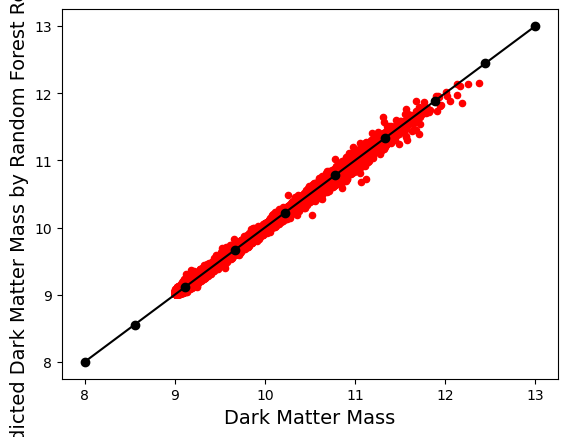

In [50]:
FORegressor = RandomForestRegressor()
FORegressor.fit(X_train, Y_train)
FOft = FORegressor.feature_importances_
print ("feature importance : ", FOft)

FOY_pred = FORegressor.predict(X_test)
print ("prediction : ", FOY_pred)

FOR = r2_score(Y_test, FOY_pred)
print ("R2 Score : ", FOR)

FOMse = mean_squared_error(Y_test, FOY_pred)
print ("The mean square value : ", FOMse)

FOScores = cross_validate(FORegressor,Features,Target, cv = KFold(n_splits=7, shuffle=True, random_state=10), return_train_score=True)
FOS = np.mean(FOScores['test_score'])
print ("The Score : ", FOScores)
print ("Test Score : ", FOS)
print ("Train Score : ", np.mean(FOScores['train_score']))

FOCvpred = cross_val_predict(FORegressor,Features,Target, cv = KFold(n_splits=7, shuffle=True, random_state=10))
print ("Cross Vaidate prediction : ", FOCvpred)

FC_coeff, FP_value = stats.pearsonr(FOCvpred.reshape((17255,)), Target)
print("Pearson Correlation Coefficient:", FC_coeff)
print("P-value:", FP_value)

m = np.linspace(8, 13, 10)
n = m
plt.plot(m, n, color='black', linestyle='-', marker='o')

plt.scatter(Target,FOCvpred, s = 20, c = 'red')
plt.xlabel('Dark Matter Mass', fontsize=14)
plt.ylabel('Predicted Dark Matter Mass by Random Forest Regressor',fontsize=14)

feature importance :  [0.00567721 0.0167659  0.02547668 0.03029508 0.02918744 0.14303568
 0.23038934 0.24537447 0.2737982 ]
prediction :  [ 9.16422093 10.67680567 10.34272826 ...  9.49147039  9.1539019
  9.43266672]
R2 Score :  0.9955986399944887
The mean square value :  0.0013877114641656777
The Score :  {'fit_time': array([5.81107855, 5.95292568, 4.7826097 , 5.13038969, 4.60742235,
       5.30328631, 5.75985694]), 'score_time': array([0.11471677, 0.17911816, 0.12036276, 0.15740919, 0.15930223,
       0.11492944, 0.15888262]), 'test_score': array([0.99540351, 0.99573442, 0.99560712, 0.99580912, 0.99601729,
       0.9951788 , 0.99560303]), 'train_score': array([1., 1., 1., 1., 1., 1., 1.])}
Test Score :  0.9956219010731564
Train Score :  1.0
Cross Vaidate prediction :  [11.92050789 11.84090718 11.41605447 ...  9.03425104  9.03517753
  9.02391267]
Pearson Correlation Coefficient: 0.9978108363424383
P-value: 0.0


Text(0, 0.5, 'Predicted Dark Matter Mass by Extreme Random Forest Regressor')

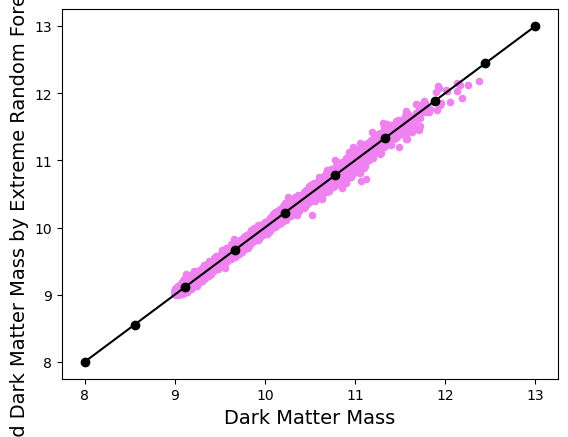

In [51]:
ETRegressor = ExtraTreesRegressor(n_estimators=100, random_state=33)
ETRegressor.fit(X_train, Y_train)
ETft = ETRegressor.feature_importances_
print ("feature importance : ", ETft)

ETY_pred = ETRegressor.predict(X_test)
print ("prediction : ", ETY_pred)

ETR = r2_score(Y_test, ETY_pred)
print ("R2 Score : ", ETR)

ETMse = mean_squared_error(Y_test, ETY_pred)
print ("The mean square value : ", ETMse)

ETScores = cross_validate(ETRegressor,Features,Target, cv = KFold(n_splits=7, shuffle=True, random_state=10), return_train_score=True)
ETS = np.mean(ETScores['test_score'])
print ("The Score : ", ETScores)
print ("Test Score : ", ETS)
print ("Train Score : ", np.mean(ETScores['train_score']))

ETCvpred = cross_val_predict(ETRegressor,Features,Target, cv = KFold(n_splits=7, shuffle=True, random_state=10))
print ("Cross Vaidate prediction : ", ETCvpred)

ETC_coeff, ETP_value = stats.pearsonr(ETCvpred.reshape((17255,)), Target)
print("Pearson Correlation Coefficient:", ETC_coeff)
print("P-value:", ETP_value)

m = np.linspace(8, 13, 10)
n = m
plt.plot(m, n, color='black', linestyle='-', marker='o')

plt.scatter(Target,ETCvpred, s = 20, c = 'violet')
plt.xlabel('Dark Matter Mass', fontsize=14)
plt.ylabel('Predicted Dark Matter Mass by Extreme Random Forest Regressor',fontsize=14)

 Model Comparisons for Case 2 


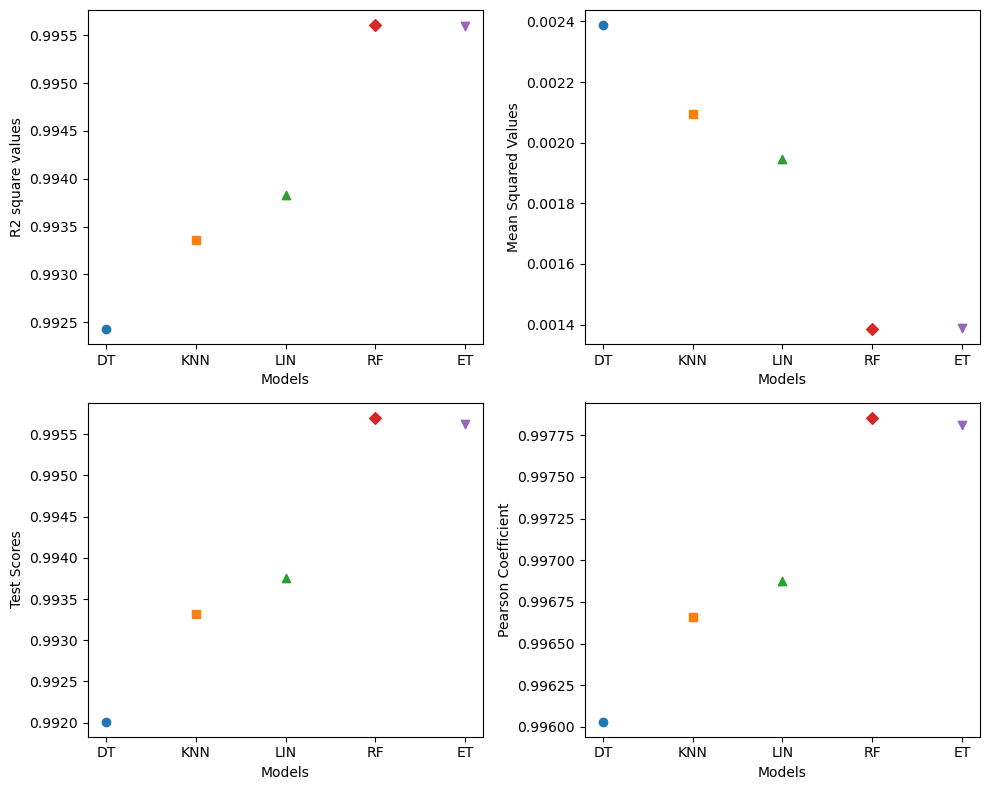

In [56]:
# COMPARISON GRAPH (CASE 2)

print ("\033[1m Model Comparisons for Case 2 \033[0m")

plt.figure(figsize=(10, 8))

plt.subplot(2, 2, 1)
#R square
plt.plot(figsize=(4, 4))
g = [R, KR, LR, FOR, ETR]
h = ['DT', 'KNN', 'LIN', 'RF', 'ET']
shapes = ['o', 's', '^', 'D', 'v']
for i in range(len(g)):
    plt.scatter(h[i], g[i], marker=shapes[i])
plt.xlabel('Models')
plt.ylabel('R2 square values')

#Mean Squared Error

plt.subplot(2, 2, 2)
plt.plot(figsize=(4, 4))
gg = [Mse, KMse, LMse, FOMse, ETMse]
hh = ['DT', 'KNN', 'LIN', 'RF', 'ET']
shapes = ['o', 's', '^', 'D', 'v']
for i in range(len(gg)):
    plt.scatter(hh[i], gg[i], marker=shapes[i])
plt.xlabel('Models')
plt.ylabel('Mean Squared Values')

#Test Scores

plt.subplot(2, 2, 3)
plt.plot(figsize=(4, 4))
G = [S, KS, LS, FOS, ETS]
H = ['DT', 'KNN', 'LIN', 'RF', 'ET']
shapes = ['o', 's', '^', 'D', 'v']
for j in range(len(G)):
    plt.scatter(H[j], G[j], marker=shapes[j])
plt.xlabel('Models')
plt.ylabel('Test Scores')

#Pearson Correlation

plt.subplot(2, 2, 4)
plt.plot(figsize=(4, 4))
GC = [C_coeff, KC_coeff, LC_coeff, FC_coeff, ETC_coeff]
HC = ['DT', 'KNN', 'LIN', 'RF', 'ET']
shapes = ['o', 's', '^', 'D', 'v']
for j in range(len(GC)):
    plt.scatter(HC[j], GC[j], marker=shapes[j])
plt.xlabel('Models')
plt.ylabel('Pearson Coefficient')

plt.tight_layout()
plt.savefig('FOSM Mass comparisons.png')
plt.show()

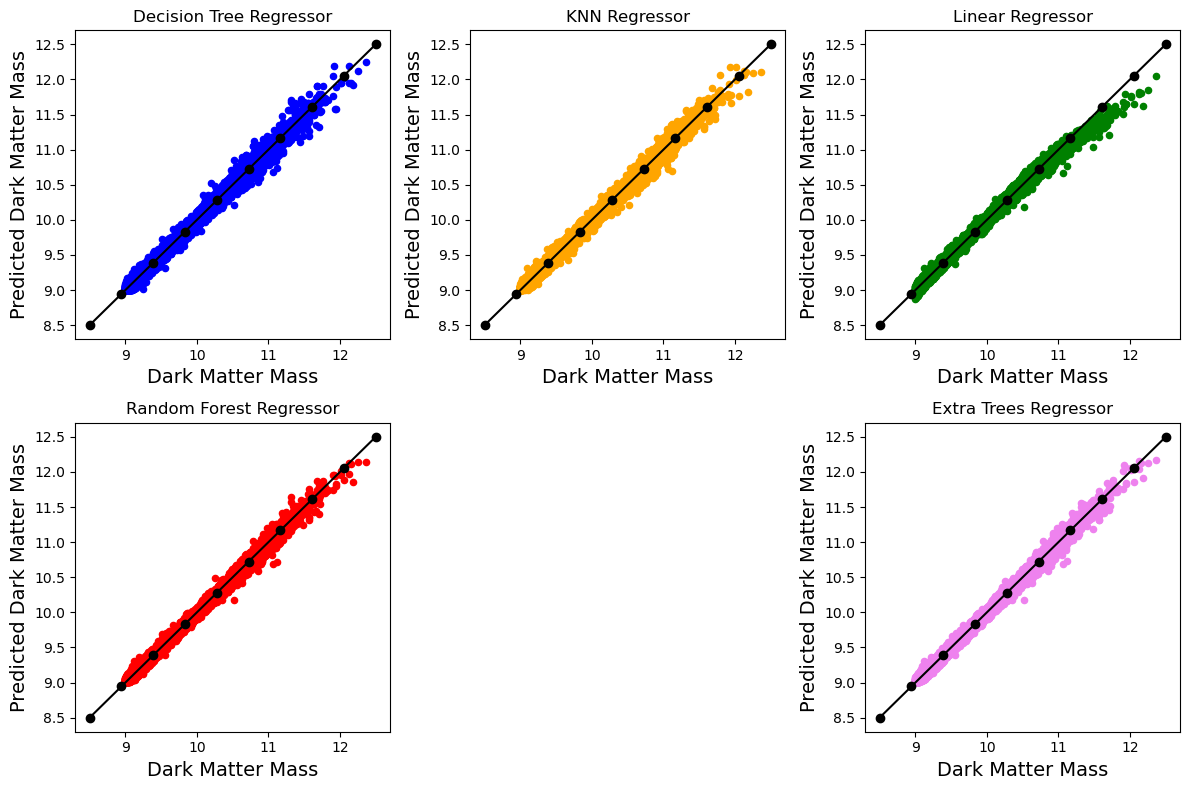

In [55]:
plt.figure(figsize=(12, 8))

# DT
plt.subplot(2, 3, 1)
m = np.linspace(8.5, 12.5, 10)
n = m
plt.plot(m, n, color='black', linestyle='-', marker='o')

plt.scatter(Target,Cvpred, s = 20, c = 'blue')
plt.xlabel('Dark Matter Mass', fontsize=14)
plt.ylabel('Predicted Dark Matter Mass',fontsize=14)
plt.title('Decision Tree Regressor')

# KNN
plt.subplot(2, 3, 2)
m = np.linspace(8.5, 12.5, 10)
n = m
plt.plot(m, n, color='black', linestyle='-', marker='o')

plt.scatter(Target,KCvpred, s = 20, c = 'orange')
plt.xlabel('Dark Matter Mass', fontsize=14)
plt.ylabel('Predicted Dark Matter Mass',fontsize=14)
plt.title('KNN Regressor')

# LIN
plt.subplot(2, 3, 3)
m = np.linspace(8.5, 12.5, 10)
n = m
plt.plot(m, n, color='black', linestyle='-', marker='o')

plt.scatter(Target,LCvpred, s = 20, c = 'green')
plt.xlabel('Dark Matter Mass', fontsize=14)
plt.ylabel('Predicted Dark Matter Mass',fontsize=14)
plt.title('Linear Regressor')

# RF
plt.subplot(2, 3, 4)
m = np.linspace(8.5, 12.5, 10)
n = m
plt.plot(m, n, color='black', linestyle='-', marker='o')

plt.scatter(Target,FOCvpred, s = 20, c = 'red')
plt.xlabel('Dark Matter Mass', fontsize=14)
plt.ylabel('Predicted Dark Matter Mass',fontsize=14)
plt.title('Random Forest Regressor')


# ETR
plt.subplot(2, 3, 6)
m = np.linspace(8.5, 12.5, 10)
n = m
plt.plot(m, n, color='black', linestyle='-', marker='o')

plt.scatter(Target,ETCvpred, s = 20, c = 'violet')
plt.xlabel('Dark Matter Mass', fontsize=14)
plt.ylabel('Predicted Dark Matter Mass',fontsize=14)
plt.title('Extra Trees Regressor')

plt.tight_layout()
plt.savefig('FOSM Mass models.png')
plt.show()